## San Francisco Crime Classification
### Predict the category of crimes that occurred in the city by the bay


![Getting Started](sf1.jpg)

Image: https://unsplash.com/@mvdheuvel
  

From Sunset to SOMA, and Marina to Excelsior, this competition's dataset provides nearly 12 years of crime reports from across all of San Francisco's neighborhoods. Given time and location, you must predict the category of crime that occurred.

In [40]:
#
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from matplotlib import rcParams

%config InlineBackend.figure_format = 'retina'
sns.set_style("white")
rcParams['figure.figsize'] = 6,4
import matplotlib.ticker as ticker

from sklearn.preprocessing import RobustScaler # hay outliers
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

In [27]:
path = r"C:\Users\gonza\OneDrive\Documentos\datascience-thebridge-master\ejercicios gonzalo\DATA\sf-crime"
file = "train.csv"
# change astype to np.float32 to reduce memory usage
df = pd.read_csv(os.path.join(path,file),dtype={"X":np.float32,"Y":np.float32})

In [28]:
df.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424362,37.800415


In [29]:
# remove duplicates
print(df.duplicated(keep=False).value_counts())
df = df.drop_duplicates()

False    873688
True       4361
dtype: int64


In columns X and Y there seem to be outliers (Y = 90.0000); it seems that this event belongs to another location. So we will remove it !

In [30]:
df[["X","Y"]].describe()

,X,Y
count,875726.000000,875726.000000
mean,-121.901985,37.958752
std,0.521390,0.494508
min,-122.513641,37.707878
25%,-122.432953,37.752426
50%,-122.416443,37.775421
75%,-122.406960,37.784378
max,-120.500000,90.000000


Now let's see some information about the non-numeric columns.
The most repeated category is LARCENY/THEFT; Fridays seem to be quite entertaining and in SOUTHERN I don't think they get bored. 	

In [31]:
df.describe(include="object")

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,875726,875726,875726,875726,875726,875726,875726
unique,389257,39,879,7,10,17,23228
top,2011-01-01 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,185,174320,59765,133371,156528,525122,26245


We are going to extract information from the columns Date and Adress; for example we can have columns like Year, Month, DayofWeek,Weekend,Minute; and from Adress the cases happen either in a street (ST) or block (Block), so we can create a column called "Block".	

We will also use LabelEncoder to transform the "Category" and "PdDistrict" columns.

In [32]:
def convert_dataframe(df):
    """
    remove outliers and create time and block columns. Convert to np.int32 
    due to memory usage
    """
    
    # time columns
    df["Dates"] = pd.to_datetime(df["Dates"],infer_datetime_format=True)
    df["Year"] = df["Dates"].dt.year.astype(np.int32)
    df["Month"] = df["Dates"].dt.month.astype(np.int32)
    df["Day"] = df["Dates"].dt.day.astype(np.int32)
    df["Hour"] = df["Dates"].dt.hour.astype(np.int32)
    df["Minute"] = df["Dates"].dt.minute.astype(np.int32)
    df["Day_week_numeric"] = df["Dates"].dt.dayofweek.astype(np.int32)
    df["Weekend"]= np.where((df["Day_week_numeric"] >= 4) & (df["Day_week_numeric"] <=6),1,0)
    # create block column from Adress column
    df["Block"] = df.Address.str.contains("Block").astype(np.int32)
    return df

In [37]:
df_date = convert_dataframe(df)

In [38]:
# label encoder Category and PdDistrict
def label_dataframe(df):
    label = LabelEncoder()
    df["Category_encode"] = label.fit_transform(df.Category)
    df["PdDistric_encode"] = label.fit_transform(df.PdDistrict)
    return df

In [41]:
df_label = label_dataframe(df_date)

In [42]:
df_label.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,Year,Month,Day,Hour,Minute,Day_week_numeric,Weekend,Block,Category_encode,PdDistric_encode
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597,2015,5,13,23,53,2,0,0,37,4
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425888,37.774597,2015,5,13,23,53,2,0,0,21,4
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424362,37.800415,2015,5,13,23,33,2,0,0,21,4


In [43]:
# remove outliers
df_outliers = df_label.loc[df.Y < 90.].copy()

### EDA
We have already prepared the dataframe, so now we can do an exploratory analysis to see what information we can obtain.

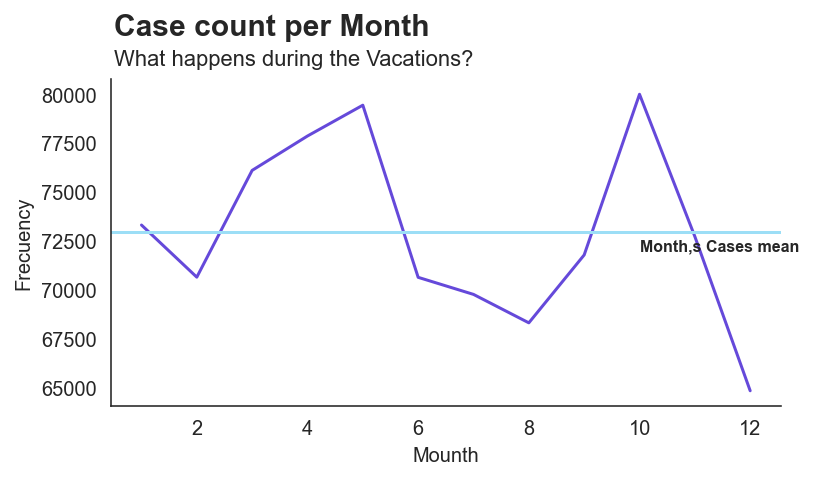

In [59]:
# count values (we can use value_counts() as well)
month_count = df_outliers.groupby(["Month"])["Dates"].count().reset_index()
plt.figure(figsize=(6,3))
ax = sns.lineplot(x="Month",y="Dates",data=month_count,color="#6549DA")
# add horizontal line
ax.axhline(month_count['Dates'].mean(),color="#9CDEF6")
sns.despine()
# adding text
ax.text(0.5,83000,"Case count per Month",
        fontsize=15,        
         fontweight='bold') 
ax.text(0.5,81500,"What happens during the Vacations?",
        fontsize=11)
ax.text(10,72000,"Month,s Cases mean",
        fontsize=8,        
         fontweight='bold')
plt.xlabel("Mounth")
plt.ylabel("Frecuency")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

At first glance, it seems that during the summer and Christmas months the number of cases is below the monthly average.

Let's do the same but with the days of the week to see if we can see any difference.
We can see that cases go up a bit during Wednesdays and Fridays; Sundays are quieter.  The range is between 132500 and 117500.

Many will think it is common sense that during the vacation months and Sundays there are fewer cases, but it never hurts to show it in a graph.

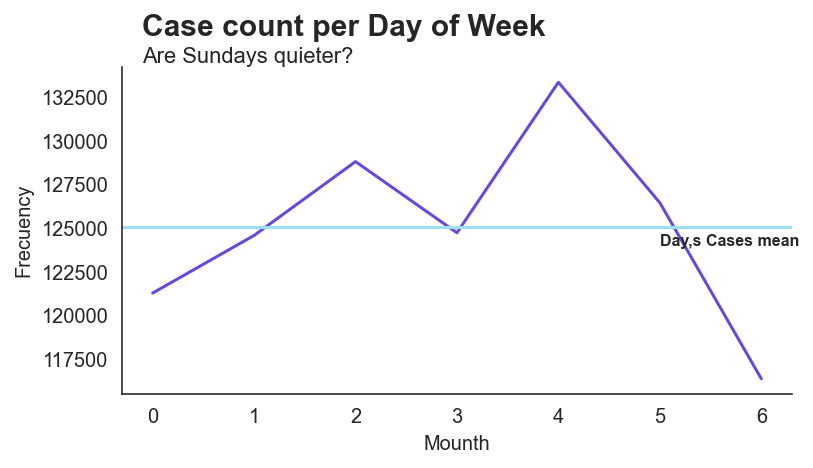

In [74]:
day_count = df_outliers.groupby(["Day_week_numeric"])["Dates"].count().reset_index()
plt.figure(figsize=(6,3))
ax = sns.lineplot(x="Day_week_numeric",y="Dates",data=day_count,color="#6549DA")
# add horizontal line
ax.axhline(day_count['Dates'].mean(),color="#9CDEF6")
sns.despine()
# add text
ax.text(-0.1,136000,"Case count per Day of Week",
        fontsize=15,        
         fontweight='bold') 
ax.text(-0.1,134500,"Are Sundays quieter?",
        fontsize=11)
ax.text(5,124000,"Day,s Cases mean",
        fontsize=8,        
         fontweight='bold')
# axis title
plt.xlabel("Mounth")
plt.ylabel("Frecuency")
# so only the graphic appears without any text referring to the object type.
plt.show(block=False)

It is not surprising that, if we graph the cases by time of day, we see that during the night there are fewer cases.

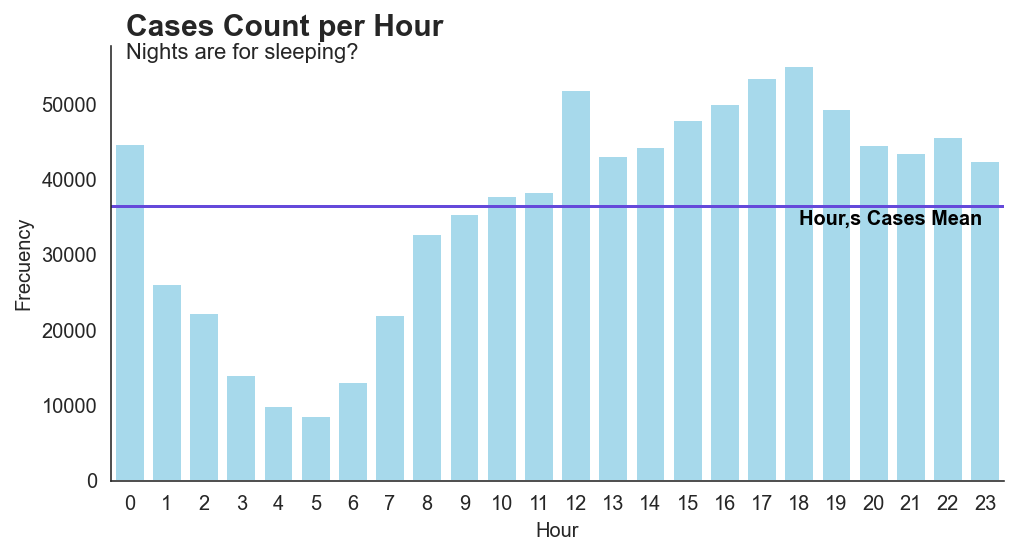

In [90]:
hour_count = df_outliers.groupby(["Hour"])["Dates"].count().reset_index()
plt.figure(figsize=(8,4))
ax = sns.barplot(y="Dates",x="Hour",data=hour_count,color="#9CDEF6")
# with axvline we can draw a vertical line
ax.axhline(hour_count["Dates"].mean(),color="#6549DA")

plt.ylabel("Frecuency")
plt.xlabel("Hour")
plt.grid(False)
sns.despine()

# add text anotation
ax.text(18,34000, "Hour,s Cases Mean", horizontalalignment='left', size='medium', color='black', weight='semibold')
ax.text(-0.1,59000,"Cases Count per Hour",
        fontsize=15,        
         fontweight='bold') 
ax.text(-0.1,56000,"Nights are for sleeping?",
        fontsize=11) 
plt.show(block=False)


No handles with labels found to put in legend.


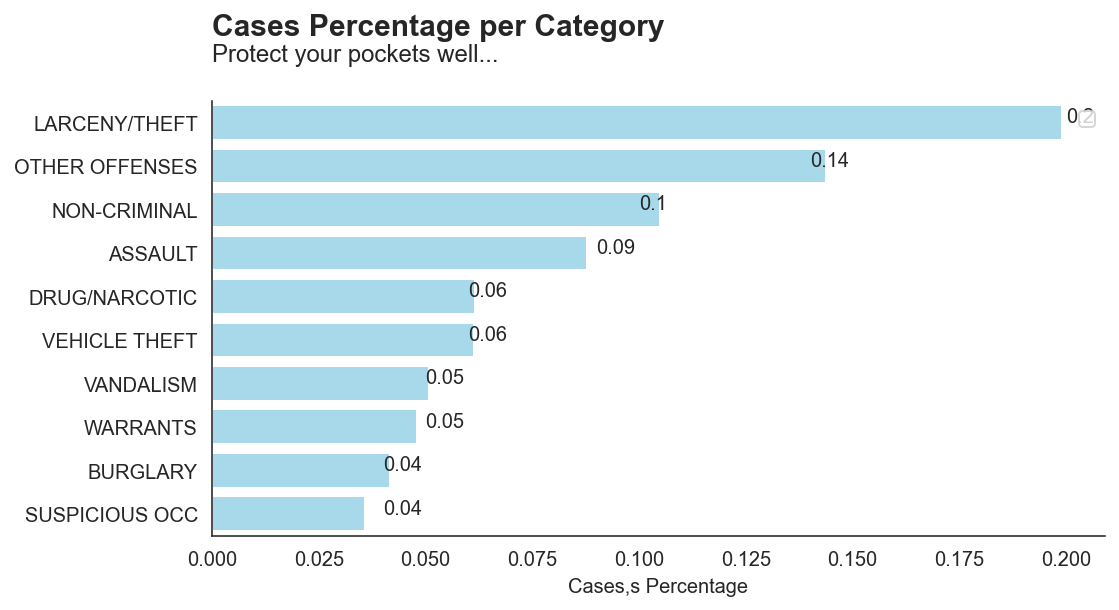

In [95]:
#plot
category_counts = df_outliers.Category.value_counts(normalize=True).reset_index().head(10)
plt.figure(figsize=(8,4))
ax=sns.barplot(y="index",x="Category",data=category_counts,color="#9CDEF6")

plt.ylabel("")
plt.xlabel("Cases,s Percentage")
plt.grid(False)
sns.despine()
plt.legend()
ax.text(0,-2,"Cases Percentage per Category",
        fontsize=15,        
         fontweight='bold') 
ax.text(0,-1.4,"Protect your pockets well...",
        fontsize=12)
# with a loop I add the values to the graphic
for num,text in zip(range(10),round(category_counts["Category"],2)):
    ax.text(text,num,text)
plt.show(block=False)